### Base visualizations for presentation:
 
    
I would include in my explanatory analysis the following:
___
- vis #15 - mean flight speed, as this metric is an essential piece of infomation about flights that was not originally included in the dataset.
- vis #12 - Distribution of flight distance. This vis combined with the speed visualization could comprehensively describe flight air time metric.
___
- vis #11 - mean ground time, beacause it is a useful metirc in observing how much time of a given flight is actually spent within airports. This data is as well not given in the dataset, but I find it interesting to present, as it can offer a different perpective to look on each carrier's performance.
- vis #6 - avg. air times by unique carrier, should present on the same dashboard with avg. ground time, in order to show two sides of the flight process.
___
- vis #4 - yearly flight counts by carrier.


# Flight Carrier Performance And Flight Motion Analysis

## Investigation Overview

I thoroughly inspected the flights data to find interesting and meaningful insights about it. Eventually, there were two aspects that intrigued me the most: the different carriers and their performance and flight motion metrics. Therefore, I've decided to include in my explanatory analysis three visualizations, the first describing flight motion, and the other two carrier performance.

## Dataset Overview

This is a flights analysis based on a dataset containing various flight metrics. The entire dataset is very memory consuming, even when heavily optimized, so I had to use a sample in my analysis in order to create visualizations. The sample I used contains 9000 from years 2000-2008, 1000 records for each year.

In [1]:
from load import get_years # Additional info within module.
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, patches
import seaborn as sns
import warnings
from math import floor, ceil
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
def drop_outliers(data, value_col, p=5, category_col=None):
    """Return DataFrame without overflow values."""
    def trunc(frame):  
        top, bottom = np.nanpercentile(a=frame[value_col], q=[100 - p / 2, p / 2])
        return frame[(frame[value_col] >= bottom) & (frame[value_col] <= top)].copy()
    if category_col:
        if data[category_col].dtype != 'category':
            raise TypeError('Category_col dtype should be categorical.')
        objs = [trunc(data[data[category_col] == item]) for item in data[category_col].cat.categories]
        return pd.concat(objs, ignore_index=True)
    else:
        return trunc(data)

In [3]:
df = get_years(year_range=(2000, 2008))
base_color = sns.color_palette()[0]

# Distribution Of Flight Speed And Distance

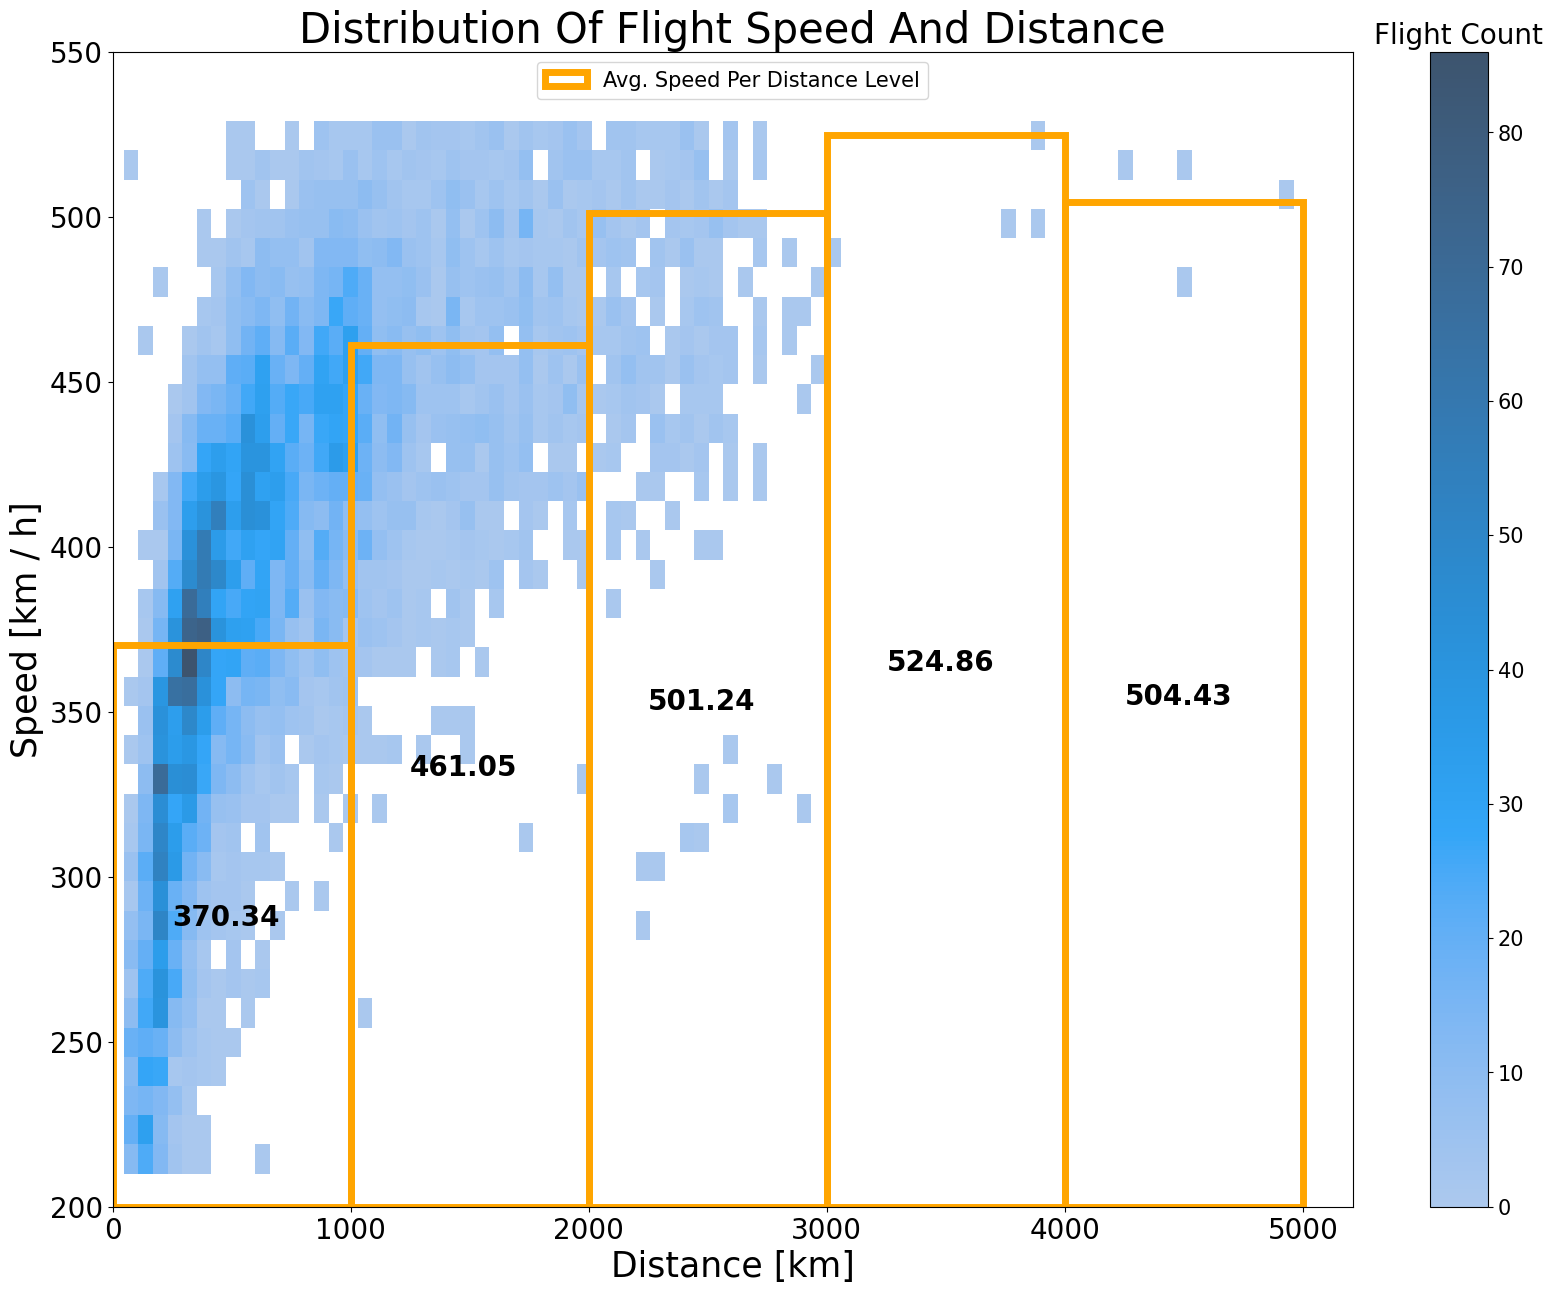

In [4]:
speed = pd.Series(df['Distance'] / df['AirTime'] * 60, 
                  name='speed', dtype='float64')
bins = np.arange(0, df.Distance.max() + 1000, 1000)
cat_distance=pd.cut(x=df.Distance, bins=bins)
temp = pd.concat([cat_distance, speed], axis=1)
speed_means = temp.groupby('Distance', as_index=False).mean()
fig, ax = plt.subplots(figsize=(20,15))
chart_data = pd.concat([df['Distance'], speed], axis=1)
chart_data = drop_outliers(data=chart_data, value_col='speed')
sns.histplot(data=chart_data,x='Distance', y='speed', cbar=True, ax=ax)
ax.set_xlim(0)
ymin = floor(chart_data.speed.min() / 50) * 50
ymax = ceil(chart_data.speed.max() / 50) * 50
ax.set_ylim(ymin, ymax)
ax.set_xticks(bins)
ax.set_title('Distribution Of Flight Speed '
             'And Distance', fontsize=30)
ax.set_xlabel('Distance [km]', fontsize=25)
ax.set_ylabel('Speed [km / h]', fontsize=25)
for i in range(len(speed_means)):
    interval = speed_means.loc[i, 'Distance']
    mean = speed_means.loc[i, 'speed']
    if i == 0:
        rec = patches.Rectangle(xy=(interval.left, ymin), 
                                width=interval.right - interval.left,
                                height=mean - ymin, fc='none', ec='orange', lw=5, label='Avg. Speed Per Distance Level')
    else:
        rec = patches.Rectangle(xy=(interval.left, ymin), 
                                width=interval.right - interval.left,
                                height=mean - ymin, fc='none', ec='orange', lw=5)
    ax.add_patch(rec)
    annot_x = rec.get_x() + rec.get_width() / 4
    annot_y = rec.get_y() + rec.get_height() / 2
    ax.text(x=annot_x, y=annot_y, s='{:.2f}'.format(mean), fontsize=20, fontweight='bold')
ax.tick_params(labelsize=20)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_title('Flight Count', fontsize=20)
ax.legend(loc='upper center', fontsize=15)
plt.show()

# Total Elapsed Time By Carrier

In [5]:
carrier_names = pd.read_csv('data/carriers.csv')

In [6]:
def get_name(code):
    """Get carrier real name."""
    value = carrier_names['Description'][carrier_names['Code'] == code].iloc[0]
    return value.split('.')[0]

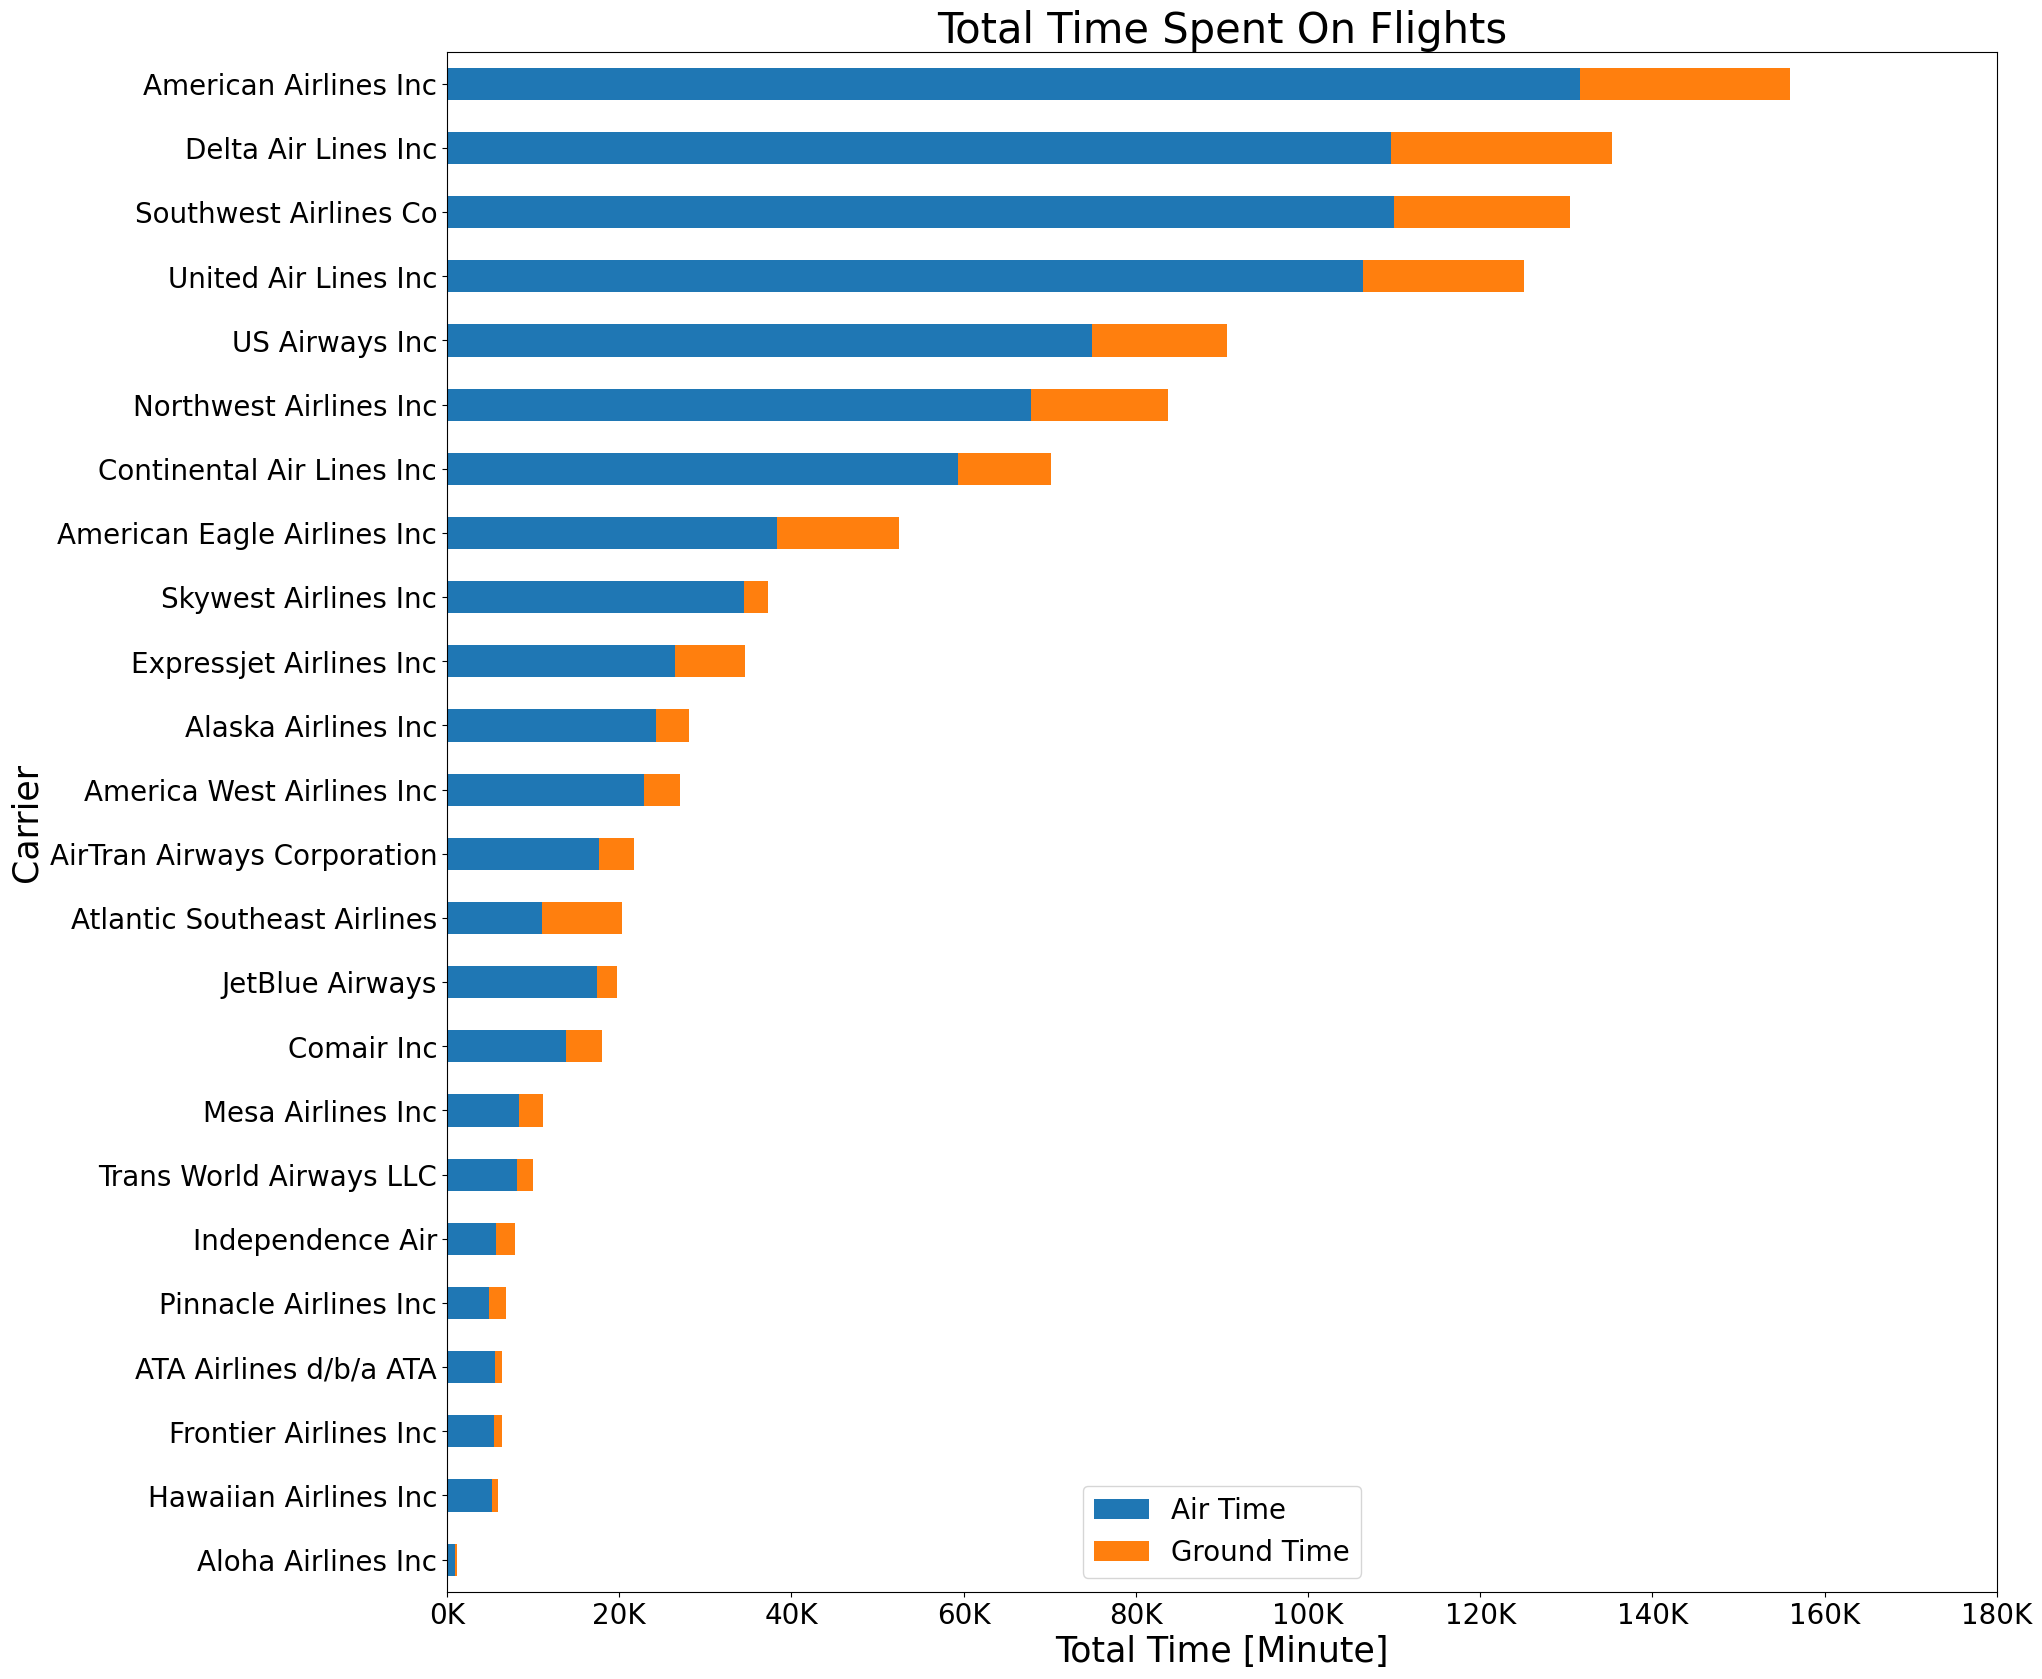

In [7]:
fig, ax = plt.subplots(figsize=(20, 20))
ground_time = pd.Series(df['ActualElapsedTime'] - df['AirTime'], name='Ground Time')
chart_data = pd.concat([df[['UniqueCarrier', 'AirTime','ActualElapsedTime']], ground_time], 
                       axis=1).groupby('UniqueCarrier').sum()
chart_data = chart_data.rename(columns={'AirTime': 'Air Time'})
chart_data = chart_data.rename(index=get_name)
chart_data = chart_data.sort_values(by='ActualElapsedTime')
temp = chart_data[['Air Time', 'Ground Time']]
temp.plot(kind='barh', stacked=True, ax=ax)
ax.legend(fontsize=15)
ax.set_xlabel('Total Time [Minute]', fontsize=25)
ax.set_ylabel('Carrier', fontsize=25)
ax.set_xticks(ax.get_xticks()) # silences a warning
current_ticks = ax.get_xticks()
if all(item % 1000 == 0 for item in current_ticks):
    tick_lbls = [f'{int(item) // 1000}K' for item in current_ticks]
    ax.set_xticklabels(tick_lbls)
ax.tick_params(labelsize=20)
ax.set_title('Total Time Spent On Flights', fontsize=30)
ax.legend(loc='lower center', fontsize=20)
plt.show()

# Vis 3 - Yearly Flight Counts By Carrier

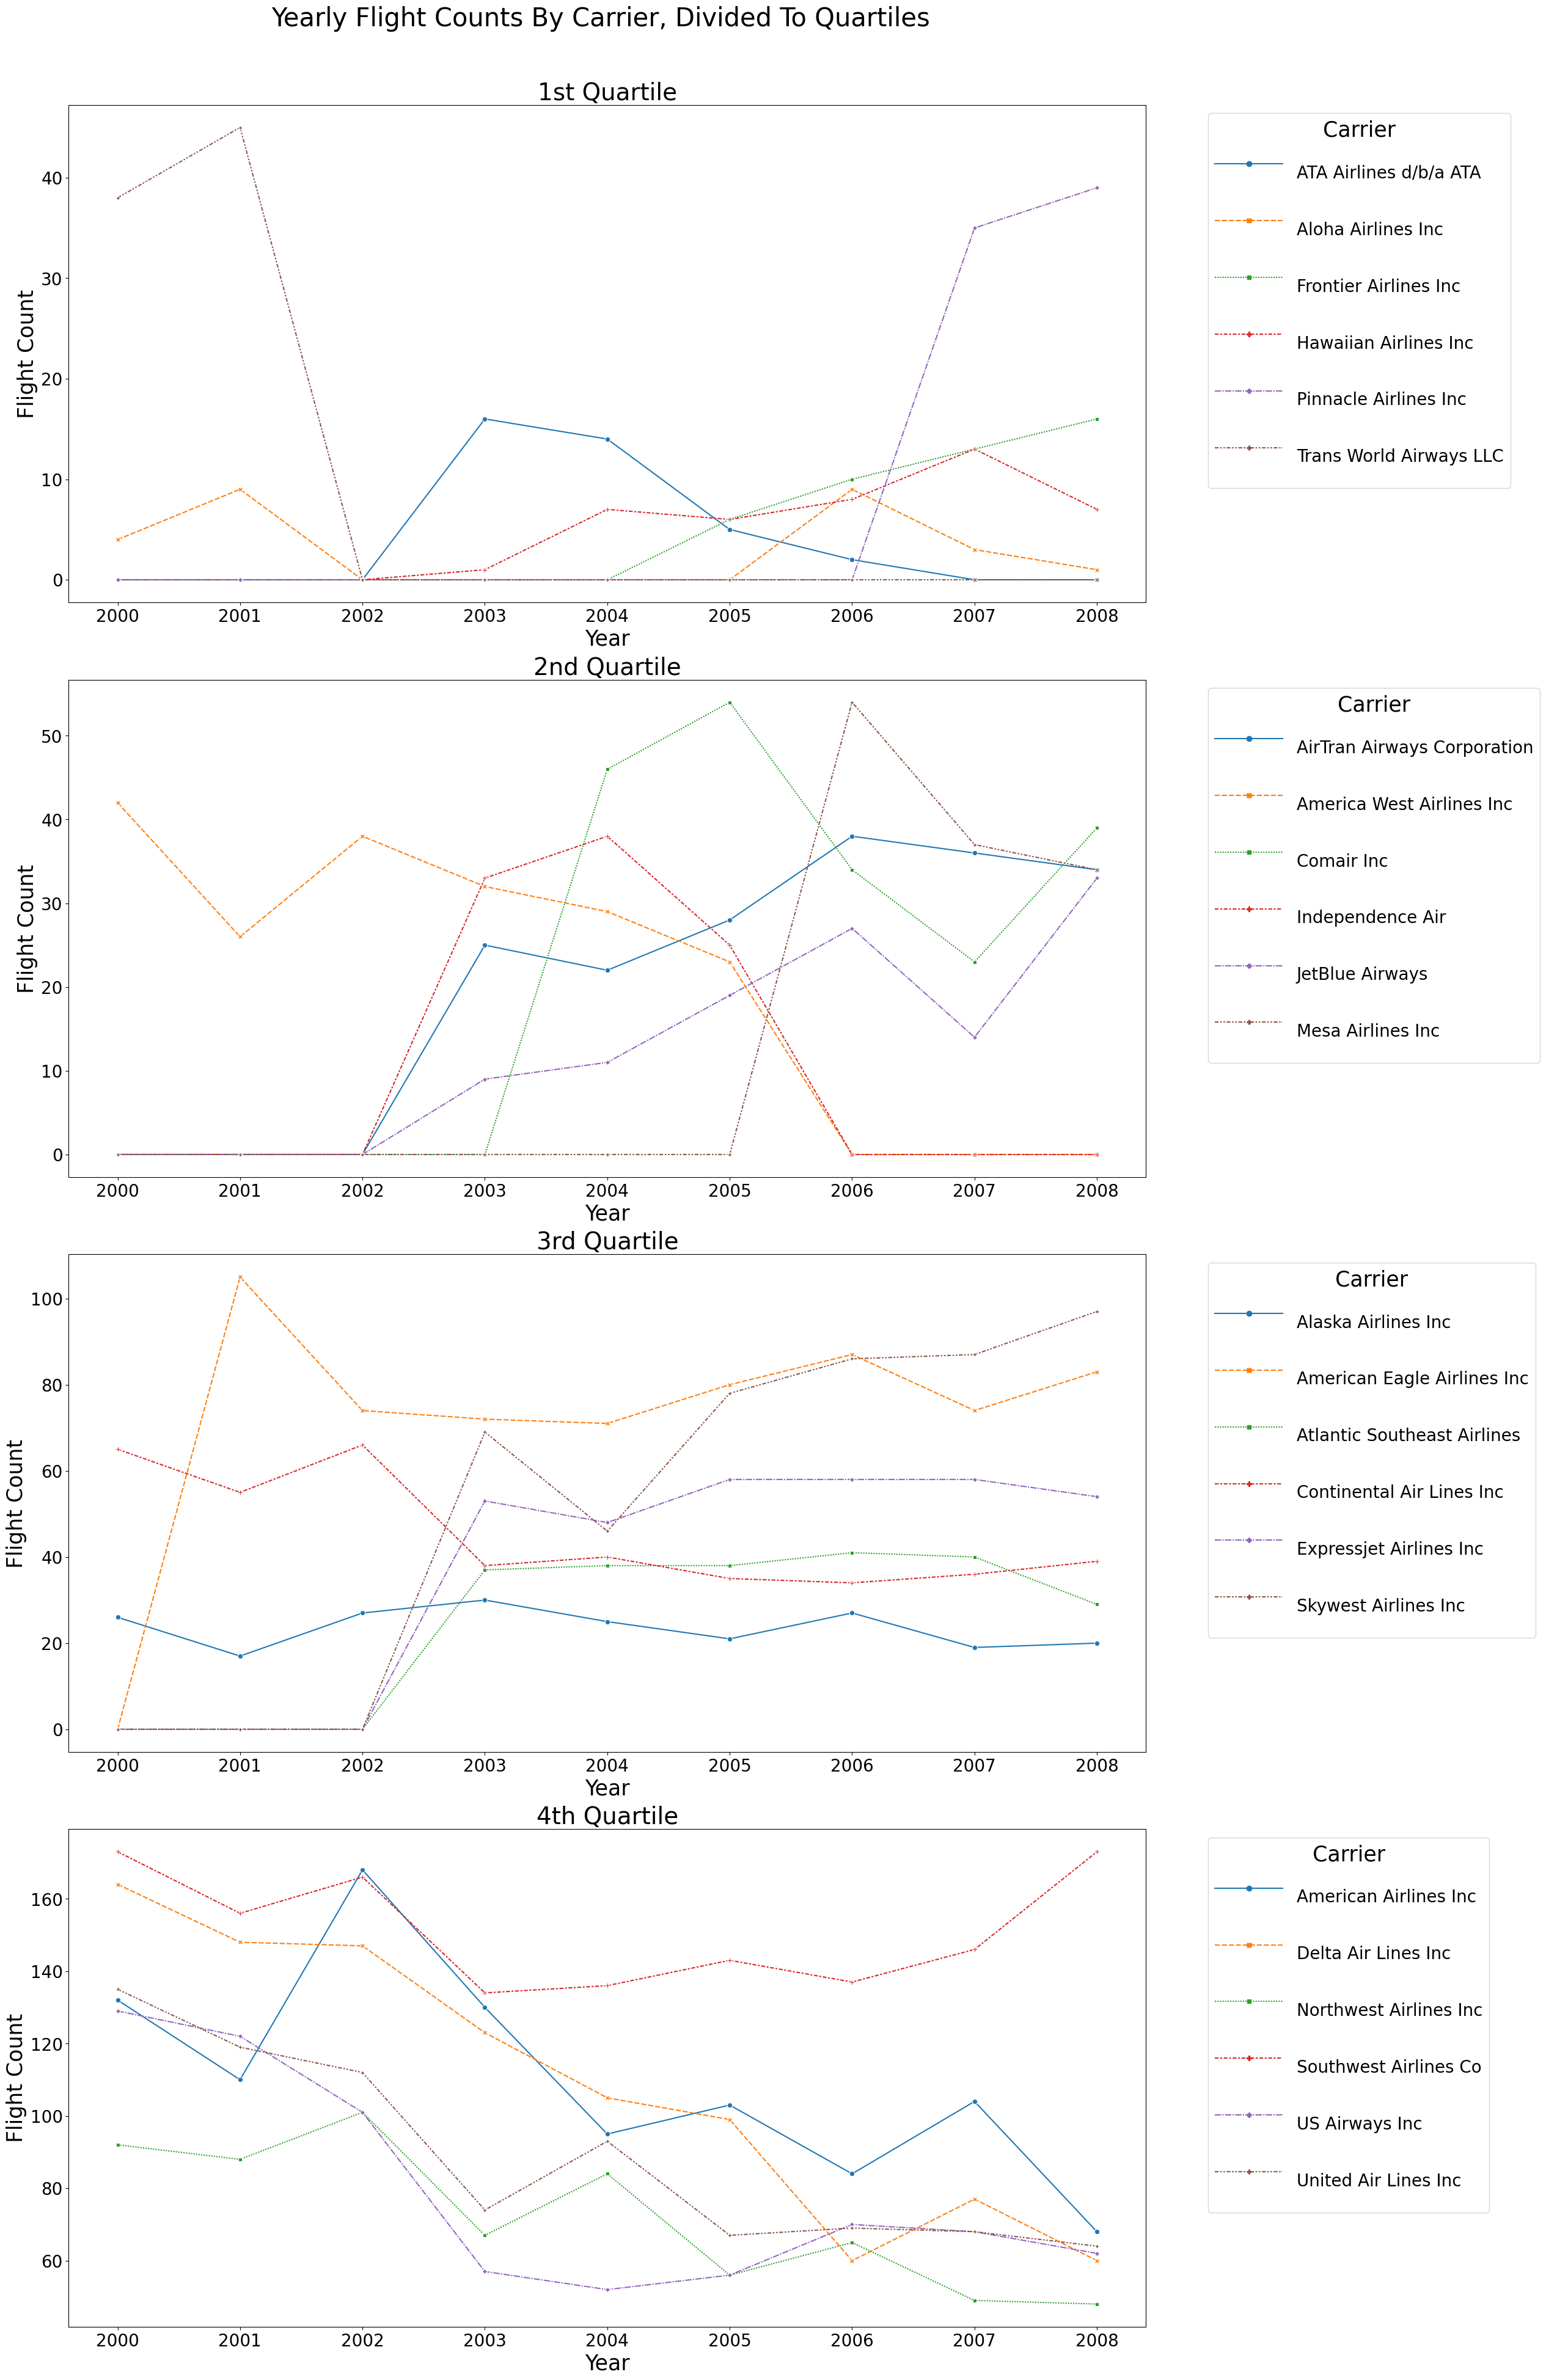

In [11]:
chart_data = df.groupby(['Year', 'UniqueCarrier'], as_index=False).size()
chart_data['UniqueCarrier'] = chart_data['UniqueCarrier'].map(get_name)

total_size = chart_data.groupby('UniqueCarrier', as_index=False).sum()
total_size['size'] = pd.qcut(total_size['size'], 4, labels=['1st', '2nd', '3rd', '4th']) 
# cut by carrier total size to quartiles

chart_data = chart_data.merge(total_size, on='UniqueCarrier').rename(columns={'UniqueCarrier': 'Carrier'})
fig, axes = plt.subplots(4, figsize=(20, 40))
fig.suptitle('Yearly Flight Counts By Carrier, Divided To Quartiles', fontsize=30)
fig.tight_layout(pad=7)
q = iter(['1st', '2nd', '3rd', '4th'])
for row in range(4):
    current_q = next(q)
    current_ax = axes[row]
    temp = chart_data[chart_data['size_y'] == current_q]
    temp = temp.astype(dtype={'Carrier': 'object'}).astype(dtype={'Carrier': 'category'})
    sns.lineplot(data=temp, x='Year', y='size_x', hue='Carrier', ax=current_ax, style='Carrier', markers=True)
    current_ax.set_title(f'{current_q} Quartile', fontsize=28)
    current_ax.tick_params(labelsize=20)
    current_ax.set_xlabel('Year', fontsize=25)
    current_ax.set_ylabel('Flight Count', fontsize=25)
    current_ax.legend(title='Carrier',title_fontsize=25, fontsize=20,
                      handlelength=4, handleheight=4, bbox_to_anchor=(1.05, 1))